In [1]:
#====================================
# Author: gmd8si
# Date: 25, November, 2016
#====================================
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import model_cam as model
from util import augment           # Questionable since we can use our own loading pipeline
import os
import matplotlib.pyplot as plt
import csv
import time
from IPython import display
#================================================
# Setting Hyper-Parameters 
#================================================

#weight_path = '../data/caffe_layers_value.pickle'
#model_path = '../models/caltech256/'
PRETRAINED_MODEL_PATH= None#'/home/gmd8si/CAM_weakly/src/bin_ckpt_dir512/model-customVGGCAM512bincombined_highres.ckpt-100' #None
#'/home/gmd8si/Weakly_detector/src/ckpt_dir/model.ckpt-0'
N_EPOCHS = 10000
INIT_LEARNING_RATE = 0.01
WEIGHT_DECAY_RATE = 0.001
MOMENTUM = 0.8
IMAGE_HEIGHT  = 256    #960
IMAGE_WIDTH   = 256    #720
NUM_CHANNELS  = 3
BATCH_SIZE = 400
N_CLASSES = 2
NUM_GPUS = 4
DROPOUT = 0.50
ckpt_dir = "./ckpt_dir256_small_test"
LOGS_PATH = './tensorflow_logs/custom256'
WEIGHT_PATH = '/opt/dl/data/retinopathy/Bosch/AEY2/log/config_CHCFall_finetuned/config_CHCFall_annealed_finetuning_Bosch2_6_14_14_4_best_acc.npy'
TRAINSET_PATH = '/home/gmd8si/CAM_weakly/data/acustomKaggle256_test_oneZeroCombined.csv'
VALSET_PATH ='/home/gmd8si/CAM_weakly/data/bincustomKaggle256_val_oneZeroCombined.csv'

In [2]:
    #=======================================================================================================
    # Reading Training data from CSV FILE
    #=======================================================================================================

csv_path = tf.train.string_input_producer([TRAINSET_PATH], shuffle=True)
textReader = tf.TextLineReader()
_, csv_content = textReader.read(csv_path)
im_name, im_label = tf.decode_csv(csv_content, record_defaults=[[""], [1]])

im_content = tf.read_file(im_name)
train_image = tf.image.decode_jpeg(im_content, channels=3)
train_image = tf.cast(train_image, tf.float32) / 255. # necessary
train_image = augment(train_image)
size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
train_image = tf.image.resize_images(train_image, size)
#label = tf.one_hot(label, 5, 1, 0 )
train_label = tf.cast(im_label, tf.int64) # unnecessary
train_image_batch, train_label_batch = tf.train.shuffle_batch([train_image, train_label], batch_size=BATCH_SIZE,
                                                             capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)

    #=======================================================================================================
    # Reading Validation data from CSV FILE
    #=======================================================================================================

val_csv_path = tf.train.string_input_producer([VALSET_PATH], shuffle=True) # No need to set no. epochs here
val_textReader = tf.TextLineReader()
_, val_content = val_textReader.read(val_csv_path)
val_image, val_label = tf.decode_csv(val_content, record_defaults=[[""], [1]])

val_image_content = tf.read_file(val_image)
val_image = tf.image.decode_jpeg(val_image_content, channels=3)
val_image = tf.cast(val_image, tf.float32) / 255. # necessary
size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
val_image = tf.image.resize_images(val_image, size)
val_label = tf.cast(val_label, tf.int64) # unnecessary
val_image_batch, val_label_batch = tf.train.shuffle_batch([val_image, val_label], batch_size=BATCH_SIZE,
                                                         capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)

In [3]:
trainfile = open(TRAINSET_PATH, "rb")
reader = csv.reader(trainfile)
trainset = sum(1 for row in reader)
print trainset
trainfile.close()

valfile = open(VALSET_PATH, "rb")
reader = csv.reader(valfile)
valset = sum(1 for row in reader)
print valset
valfile.close()

10001
1671


In [4]:
learning_rate = tf.placeholder( tf.float32, [])
images_tf = tf.placeholder( tf.float32, [None, IMAGE_HEIGHT, IMAGE_WIDTH, 3], name="images")
labels_tf = tf.placeholder( tf.int64, [None], name='labels')  # the dimensions could be [None,N_CLASSES]
detector = model.Detector(N_CLASSES, WEIGHT_PATH)

def loss_c(logits, labels):
    
    cross_entropy_mean = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels), 
                                        name='cross_entropy_mean')
    tf.add_to_collection('losses', cross_entropy_mean)
    
    # Assemble all of the losses for the current tower only.
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

In [5]:
def _tower_loss(images, labels, scope):

    # Build inference Graph.
    logits = detector.inference(images)

    # Build the portion of the Graph calculating the losses. Note that we will
    # assemble the total_loss using a custom function below.
    #split_batch_size = images.get_shape().as_list()[0]
    #inception.loss(logits, labels, batch_size=split_batch_size)
    
    _ = loss_c(logits, labels)
    
    losses = tf.get_collection('losses', scope)
    
    total_loss = tf.add_n(losses, name='total_loss')

    # Calculate the total loss for the current tower.
    #regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #total_loss = tf.add_n(losses, name='total_loss')

    # Compute the moving average of all individual losses and the total loss.
    #loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    #loss_averages_op = loss_averages.apply(losses)


    #with tf.control_dependencies([loss_averages_op]):
    #    losses = tf.identity(losses)
    
    
    correct_pred = tf.equal(tf.argmax(logits, 1), labels)
    acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    
    return total_loss, acc, logits

def _average_gradients(tower_grads):

    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(0, grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [6]:
global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
saver = tf.train.Saver() #max_to_keep=50

if not os.path.exists('./results'):
    os.makedirs('./results')
f_log = open('./results/binary_pretrain_512_large_2_12.txt', 'w')

In [7]:
#def train(dataset):
#    """Train on dataset for a number of steps."""
#tf.reset_default_graph()
#with tf.Graph().as_default():#, tf.device('/cpu:0'):
# Create a variable to count the number of train() calls. This equals the
# number of batches processed * FLAGS.num_gpus.


# Calculate the learning rate schedule.
#num_batches_per_epoch = (79819 / BATCH_SIZE)          # no. of examples / BATCH_SIZE
#decay_steps = int(num_batches_per_epoch * 10)         # num_epochs_per_decay = 10

# Decay the learning rate exponentially based on the number of steps.

#learning_rate = tf.train.exponential_decay(INIT_LEARNING_RATE, global_step, decay_steps, 0.1, staircase=True)  # Learning rate decay factor is 0.16

# Create an optimizer that performs gradient descent.
#opt = tf.train.RMSPropOptimizer(lr, RMSPROP_DECAY, momentum=RMSPROP_MOMENTUM, epsilon=RMSPROP_EPSILON)
opt = tf.train.MomentumOptimizer( learning_rate, MOMENTUM)
# Get images and labels for ImageNet and split the batch across GPUs.
assert BATCH_SIZE % NUM_GPUS == 0, ('Batch size must be divisible by number of GPUs')
split_batch_size = int(BATCH_SIZE / NUM_GPUS) # print this in sess out

# Override the number of preprocessing threads to account for the increased
# number of GPU towers.
        
##num_preprocess_threads = FLAGS.num_preprocess_threads * FLAGS.num_gpus
       
#images, labels = image_processing.distorted_inputs(dataset,
#    num_preprocess_threads=num_preprocess_threads)

#input_summaries = copy.copy(tf.get_collection(tf.GraphKeys.SUMMARIES))

# Number of classes in the Dataset label set plus 1.
# Label 0 is reserved for an (unused) background class.
        
##num_classes = dataset.num_classes() + 1
    
# Split the batch of images and labels for towers.
images_splits = tf.split(0, NUM_GPUS, images_tf)
labels_splits = tf.split(0, NUM_GPUS, labels_tf)


print 'im_split', np.shape(images_splits)
print 'la_split', np.shape(labels_splits)

# Calculate the gradients for each model tower.
tower_grads = []
acc_array=[]
for i in xrange(NUM_GPUS):
    with tf.device('/gpu:%d' % i):
        with tf.name_scope('%s_%d' % ('tower', i)) as scope:
            # Force all Variables to reside on the CPU.
            #with slim.arg_scope([slim.variables.variable], device='/cpu:0'):
                # Calculate the loss for one tower of the ImageNet model. This
                # function constructs the entire ImageNet model but shares the
                # variables across all towers.
            #loss, acc, output = _tower_loss(images_splits[i], labels_splits[i], scope)
            loss, acc, output = _tower_loss(images_tf, labels_tf, scope)
            acc_array.append(acc)
            # Reuse variables for the next tower.
            tf.get_variable_scope().reuse_variables()

                # Retain the summaries from the final tower.
                #summaries = tf.get_collection(tf.GraphKeys.SUMMARIES, scope)

                # Retain the Batch Normalization updates operations only from the
                # final tower. Ideally, we should grab the updates from all towers
                # but these stats accumulate extremely fast so we can ignore the
                # other stats from the other towers without significant detriment.
                #batchnorm_updates = tf.get_collection(slim.ops.UPDATE_OPS_COLLECTION, scope)

                # Calculate the gradients for the batch of data on this ImageNet
                # tower.
            grads = opt.compute_gradients(loss)

                # Keep track of the gradients across all towers.
            tower_grads.append(grads)

accuracy = (sum(acc_array))/4.
acc_array=[]
    # We must calculate the mean of each gradient. Note that this is the
    # synchronization point across all towers.
grads = _average_gradients(tower_grads)

    # Add a summaries for the input processing and global_step.
    #summaries.extend(input_summaries)

    # Add a summary to track the learning rate.
    #summaries.append(tf.scalar_summary('learning_rate', lr))

    # Add histograms for gradients.
    #for grad, var in grads:
    #    if grad is not None:
    #        summaries.append(tf.histogram_summary(var.op.name + '/gradients', grad))

    # Apply the gradients to adjust the shared variables.
train_op= opt.apply_gradients(grads, global_step=global_step)
##apply_gradient_op= opt.apply_gradients(grads, global_step=global_step)
    # Add histograms for trainable variables.
    #for var in tf.trainable_variables():
    #    summaries.append(tf.histogram_summary(var.op.name, var))

    # Track the moving averages of all trainable variables.
    # Note that we maintain a "double-average" of the BatchNormalization
    # global statistics. This is more complicated then need be but we employ
    # this for backward-compatibility with our previous models.
            
##variable_averages = tf.train.ExponentialMovingAverage(0.9999, global_step)  # Moving Average Decay

    # Another possiblility is to use tf.slim.get_variables().
    ##variables_to_average = (tf.trainable_variables() +
    #                        tf.moving_average_variables())
##variables_averages_op = variable_averages.apply(tf.trainable_variables())
    # Group all updates to into a single train op.
    #batchnorm_updates_op = tf.group(*batchnorm_updates)
##train_op = tf.group(apply_gradient_op, variables_averages_op)

    # Create a saver.
saver = tf.train.Saver(tf.all_variables())

    # Build the summary operation from the last tower summaries.
    #summary_op = tf.merge_summary(summaries)
    
    # Build an initialization operation to run below.
    #init = tf.initialize_all_variables()

    # Start running operations on the Graph. allow_soft_placement must be set to
    # True to build towers on GPU, as some of the ops do not have GPU
    # implementations.
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    
    if PRETRAINED_MODEL_PATH:
        print "Using Pretrained model"
        saver.restore(sess, PRETRAINED_MODEL_PATH)
    else:    
        sess.run(tf.initialize_all_variables())    
        #sess.run(tf.initialize_local_variables())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    loss_list = []
    plot_accuracy = []
    plot_loss = []
    validation_accuracy = []
    plot_lr=[]
    time_per_epoch=[]
    process_start_time= time.time()
    summary_writer = tf.train.SummaryWriter(LOGS_PATH, graph=tf.get_default_graph())
    steps = 1
    count = 1
    
    for epoch in range(200):    
        
        train_correct = 0
        train_data = 0    
        epoch_start_time = time.time()
        
        for i in range (15):           #(trainset/BATCH_SIZE +1):
            train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
            _, loss_val, off_acc, a, lr = sess.run([train_op, loss, accuracy, acc_array, 
                                                    learning_rate], feed_dict={
                    images_tf: train_imbatch, labels_tf: train_labatch, learning_rate: INIT_LEARNING_RATE})
            
            loss_list.append(loss_val)                              # This must be for visualizing loss curve 
            plot_lr.append(lr)    
                #plot_accuracy.append(off_acc)
                #plot_loss.append(loss_val)
                #print output_val, train_labatch
            
                #print loss_val, off_acc
            
                ##==============VISUALIZATION======================================
                # Select batch size of 1 to visualize it
                #print test_im.shape
                #im = np.squeeze(test_im, axis=(0,))
                #print im.shape
            
                #fig, ax = plt.subplots()
                #ax.plot(plot_accuracy,'g-', label='Training Accuracy')
                #ax.plot(plot_loss,'b.', label='Training Loss')

                #ax.legend(bbox_to_anchor=(1, 1.22))
                #ax.grid(True)
                #plt.xlabel('Iterations')
                #display.clear_output(wait=True)#
                #plt.plot(plot_loss, '.')
                #plt.show()
                #plt.imshow(im)#
                #plt.imshow(im)#
                #plt.show()#
                #print 'GROUND TRUTH', train_labatch
                #print 'PREDICTED', label_predictions
            
                ##=================================================================
            #print output_val
            #label_predictions = output_val.argmax(axis=1)
            #acc = (label_predictions == train_labatch).sum()          
            #train_correct +=acc               #No of correctly classified examples, accumulated per batch
            #train_data += len(output_val)
            
            if (steps) % 5 == 0:   # after 5 batches
                display.clear_output(wait=True)#
                print "======================================"
                print "Epoch", epoch+1, "Iteration", steps
                #print "Processed", train_data, '/', trainset               # (count*BATCH_SIZE)
                #batch_predictions = output_val.argmax(axis=1)
                #batch_acc = (batch_predictions == train_labatch).sum()
                print 'official accuracy: ', off_acc
                #print 'Training accuracy (correctly classified/num of examples) = ', (train_correct/float(train_data))
                #print "Accuracy per batch:", batch_acc
                    #print "Accuracy Percentage:", (acc/len(current_labels))*100
                loss_mean = np.mean(loss_list)
                print "Training Loss:", loss_mean
                loss_list = []
                #summary_writer.add_summary(summary, steps)
                plot_accuracy.append(off_acc)
                plot_loss.append(loss_mean)
                fig, ax = plt.subplots()
                ax.plot(plot_accuracy,'g-', label='Training Accuracy')
                ax.plot(plot_loss,'b.', label='Training Loss')
                    #handles, labels = ax.get_legend_handles_labels()
                ax.legend(bbox_to_anchor=(1, 1.22))
                ax.grid(True)
                plt.xlabel('Iterations')
                print (lr)
                    #plt.plot(plot_loss, '.')
                plt.show()
                
            steps += 1
            count += 1
        count = 1
        n_correct = 0
        n_data = 0
        
        
        for i in range (3):
            
            val_imbatch, val_labatch = sess.run([val_image_batch, val_label_batch])
            acc = sess.run(accuracy, feed_dict={images_tf:val_imbatch, labels_tf: val_labatch})
            
                # check the length of output_vals, and no. of values in n_data, correct the processed value as well
            #label_predictions = output_vals.argmax(axis=1)
            #acc = (label_predictions == val_labatch).sum()
            validation_accuracy.append(acc)
            #n_correct += acc                  # No of correctly idenified examples in whole val set
            #n_data += len(output_vals)    # len(val_labatch)
        
        #print "===========**VALIDATION ACCURACY**================"
        print 'Last value', acc
        fig, ax = plt.subplots()
        ax.plot(validation_accuracy,'g-', label='Validation Accuracy')
        #ax.plot(plot_loss,'b.', label='Training Loss')
                    #handles, labels = ax.get_legend_handles_labels()
        ax.legend(bbox_to_anchor=(1, 1.22))
        ax.grid(True)
        plt.xlabel('Iterations')
        plt.ylabel('Validation Accuracy')
        #plt.plot (validation_accuracy)
        #acc_all = n_correct / float(n_data)
        #f_log.write('epoch:'+str(epoch+1)+'\tacc:'+str(acc_all) + '\n')
        #print "===========**VALIDATION ACCURACY**================"
        #print 'epoch:'+str(epoch+1)+'\tacc:'+str(acc_all) + '\n'
        print 'Time Elapsed for Epoch:'+str(epoch+1)+' is '+str ((time.time() - epoch_start_time)/60.)#+' minutes'
        time_per_epoch.append((time.time() - epoch_start_time)/60.)
        INIT_LEARNING_RATE *= 0.99
        if (epoch % 5 == 0):            
            saver.save(sess, ckpt_dir + "/model-customVGGCAM256bincombined_highres.ckpt", global_step=epoch)
    

im_split (4,)
la_split (4,)
conv1_1w (?, 256, 256, 32)
b (32,)
conv1_2w (?, 256, 256, 32)
b (32,)
conv2_1w (?, 64, 64, 64)
b (64,)
conv2_1w (?, 64, 64, 64)
b (64,)
conv2_1w (?, 64, 64, 64)
b (64,)
conv2_1w (?, 32, 32, 128)
b (128,)
conv2_1w (?, 32, 32, 128)
b (128,)
conv2_1w (?, 32, 32, 128)
b (128,)
conv2_1w (?, 16, 16, 256)
b (256,)
conv2_1w (?, 16, 16, 256)
b (256,)
conv2_1w (?, 16, 16, 256)
b (256,)
conv2_1w (?, 8, 8, 512)
b (512,)
conv2_1w (?, 8, 8, 512)
b (512,)
conv6 shape (?, 8, 8, 1024)
gap shape (?, 1024)
conv1_1w (?, 256, 256, 32)
b (32,)
conv1_2w (?, 256, 256, 32)
b (32,)
conv2_1w (?, 64, 64, 64)
b (64,)
conv2_1w (?, 64, 64, 64)
b (64,)
conv2_1w (?, 64, 64, 64)
b (64,)
conv2_1w (?, 32, 32, 128)
b (128,)
conv2_1w (?, 32, 32, 128)
b (128,)
conv2_1w (?, 32, 32, 128)
b (128,)
conv2_1w (?, 16, 16, 256)
b (256,)
conv2_1w (?, 16, 16, 256)
b (256,)
conv2_1w (?, 16, 16, 256)
b (256,)
conv2_1w (?, 8, 8, 512)
b (512,)
conv2_1w (?, 8, 8, 512)
b (512,)
conv6 shape (?, 8, 8, 1024)
gap sh

ResourceExhaustedError: OOM when allocating tensor with shape[32,32,3,3]
	 [[Node: tower_3/conv1_2/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:3"](tower_3/conv1_1/conv1_1, conv1_2/W/read/_81)]]
	 [[Node: div_2/_515 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2822_div_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'tower_3/conv1_2/Conv2D', defined at:
  File "/opt/dl/anaconda/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/opt/dl/anaconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/gmd8si/tf/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/gmd8si/tf/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gmd8si/tf/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/gmd8si/tf/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/gmd8si/tf/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/gmd8si/tf/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/gmd8si/tf/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-b75d07207e7c>", line 59, in <module>
    loss, acc, output = _tower_loss(images_tf, labels_tf, scope)
  File "<ipython-input-5-3e28af95e599>", line 4, in _tower_loss
    logits = detector.inference(images)
  File "model_cam.py", line 97, in inference
    conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
  File "/home/gmd8si/tf/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 394, in conv2d
    data_format=data_format, name=name)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/gmd8si/tf/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,32,3,3]
	 [[Node: tower_3/conv1_2/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:3"](tower_3/conv1_1/conv1_1, conv1_2/W/read/_81)]]
	 [[Node: div_2/_515 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2822_div_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


Tensor("Placeholder:0", shape=(), dtype=float32)


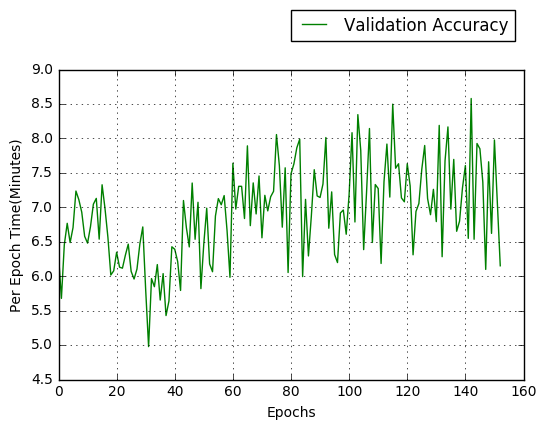

In [9]:
# print the learning rate value and remember to include learning rate plot next time
print (learning_rate)
# This will end at epoch number 11
# l

fig, ax = plt.subplots()
ax.plot(time_per_epoch,'g-', label='Validation Accuracy')
#ax.plot(plot_loss,'b.', label='Training Loss')
                    #handles, labels = ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1, 1.22))
ax.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Per Epoch Time(Minutes)')
#plt.plot (validation_accuracy)